In [460]:
from google.cloud import bigquery

from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from scipy import stats

In [461]:
import os

# Get the current working directory in a Jupyter notebook
current_dir = os.getcwd()

# Create the full path
key_path = os.path.join(current_dir, 'projet-integration-au-2024-81640cb2db70.json')

# Set the environment variable to the path of your JSON key file
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = key_path

print(f"Google Application Credentials set to: {os.environ['GOOGLE_APPLICATION_CREDENTIALS']}")

Google Application Credentials set to: c:\Users\sacha\FORK\AI_Final\projet-integration-au-2024-81640cb2db70.json


In [462]:
# Initialiser le client BigQuery
client = bigquery.Client()

# Définir le dataset_id
dataset_id = 'sacha_phishing_url_website'
table_id = 'sacha_table_initial_raw'
table_id_colinearite_vif = 'sacha_table_NA_colin'
table_id_outliers_vif = 'sacha_table_NA_outli'
table_id_outli_colin_vif = 'sacha_table_NA_outli_colin'
table_id_stagging = "sacha_table_initial_stagging"
table_id_stagging_string = "sacha_table_initial_stagging_NA_string"

In [463]:
# Exécuter une requête SQL pour charger le dataset dans un DataFrame
query = f"""
    SELECT *
    FROM `{dataset_id}.{table_id_stagging_string}`
    LIMIT 10000
"""

In [464]:
# Charger les données dans un DataFrame Pandas
df = client.query(query).to_dataframe()

# Étape 1 : Exploration initiale des données

# Afficher les premières lignes du dataset
print("Premières lignes du dataset :")
print(df.head())

# Afficher les dernières lignes du dataset
print("\nDernières lignes du dataset :")
print(df.tail())

# Afficher le type de données pour chaque colonne
print("\nTypes de données des colonnes :")
print(df.dtypes)

# Vérifier les valeurs manquantes
print("\nValeurs manquantes :")
print(df.isnull().sum())

# Afficher des statistiques descriptives
print("\nStatistiques descriptives :")
print(df.describe())

c:\Users\sacha\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Premières lignes du dataset :
   IsDomainIP  NoOfAmpersandInURL  TLDLegitimateProb  TLDLength  \
0         1.0                 0.0                0.0        2.0   
1         1.0                 0.0                0.0        3.0   
2         1.0                 0.0                0.0        3.0   
3         1.0                 0.0                0.0        2.0   
4         1.0                 0.0                0.0        2.0   

   LargestLineLength  Robots  NoOfURLRedirect  NoOfPopup  \
0               28.0     0.0              0.0        0.0   
1               29.0     0.0              0.0        0.0   
2               29.0     0.0              0.0        0.0   
3               30.0     0.0              0.0        0.0   
4               30.0     0.0              0.0        0.0   

   HasExternalFormSubmit  HasHiddenFields  HasPasswordField  Bank  Pay  \
0                    0.0              0.0               0.0   0.0  0.0   
1                    0.0              0.0               0.

In [465]:
# Vérifier la présence de valeurs manquantes dans chaque colonne
missing_data = df.isnull().sum()
print("Nombre de valeurs manquantes dans chaque colonne :")
print(missing_data)

# Calculer le pourcentage de valeurs manquantes par colonne
missing_percentage = (missing_data / len(df)) * 100
print("\nPourcentage de valeurs manquantes par colonne :")
print(missing_percentage)


Nombre de valeurs manquantes dans chaque colonne :
IsDomainIP               0
NoOfAmpersandInURL       0
TLDLegitimateProb        0
TLDLength                0
LargestLineLength        0
Robots                   0
NoOfURLRedirect          0
NoOfPopup                0
HasExternalFormSubmit    0
HasHiddenFields          0
HasPasswordField         0
Bank                     0
Pay                      0
Crypto                   0
NoOfiFrame               0
NoOfEmptyRef             0
label                    0
dtype: int64

Pourcentage de valeurs manquantes par colonne :
IsDomainIP               0.0
NoOfAmpersandInURL       0.0
TLDLegitimateProb        0.0
TLDLength                0.0
LargestLineLength        0.0
Robots                   0.0
NoOfURLRedirect          0.0
NoOfPopup                0.0
HasExternalFormSubmit    0.0
HasHiddenFields          0.0
HasPasswordField         0.0
Bank                     0.0
Pay                      0.0
Crypto                   0.0
NoOfiFrame            

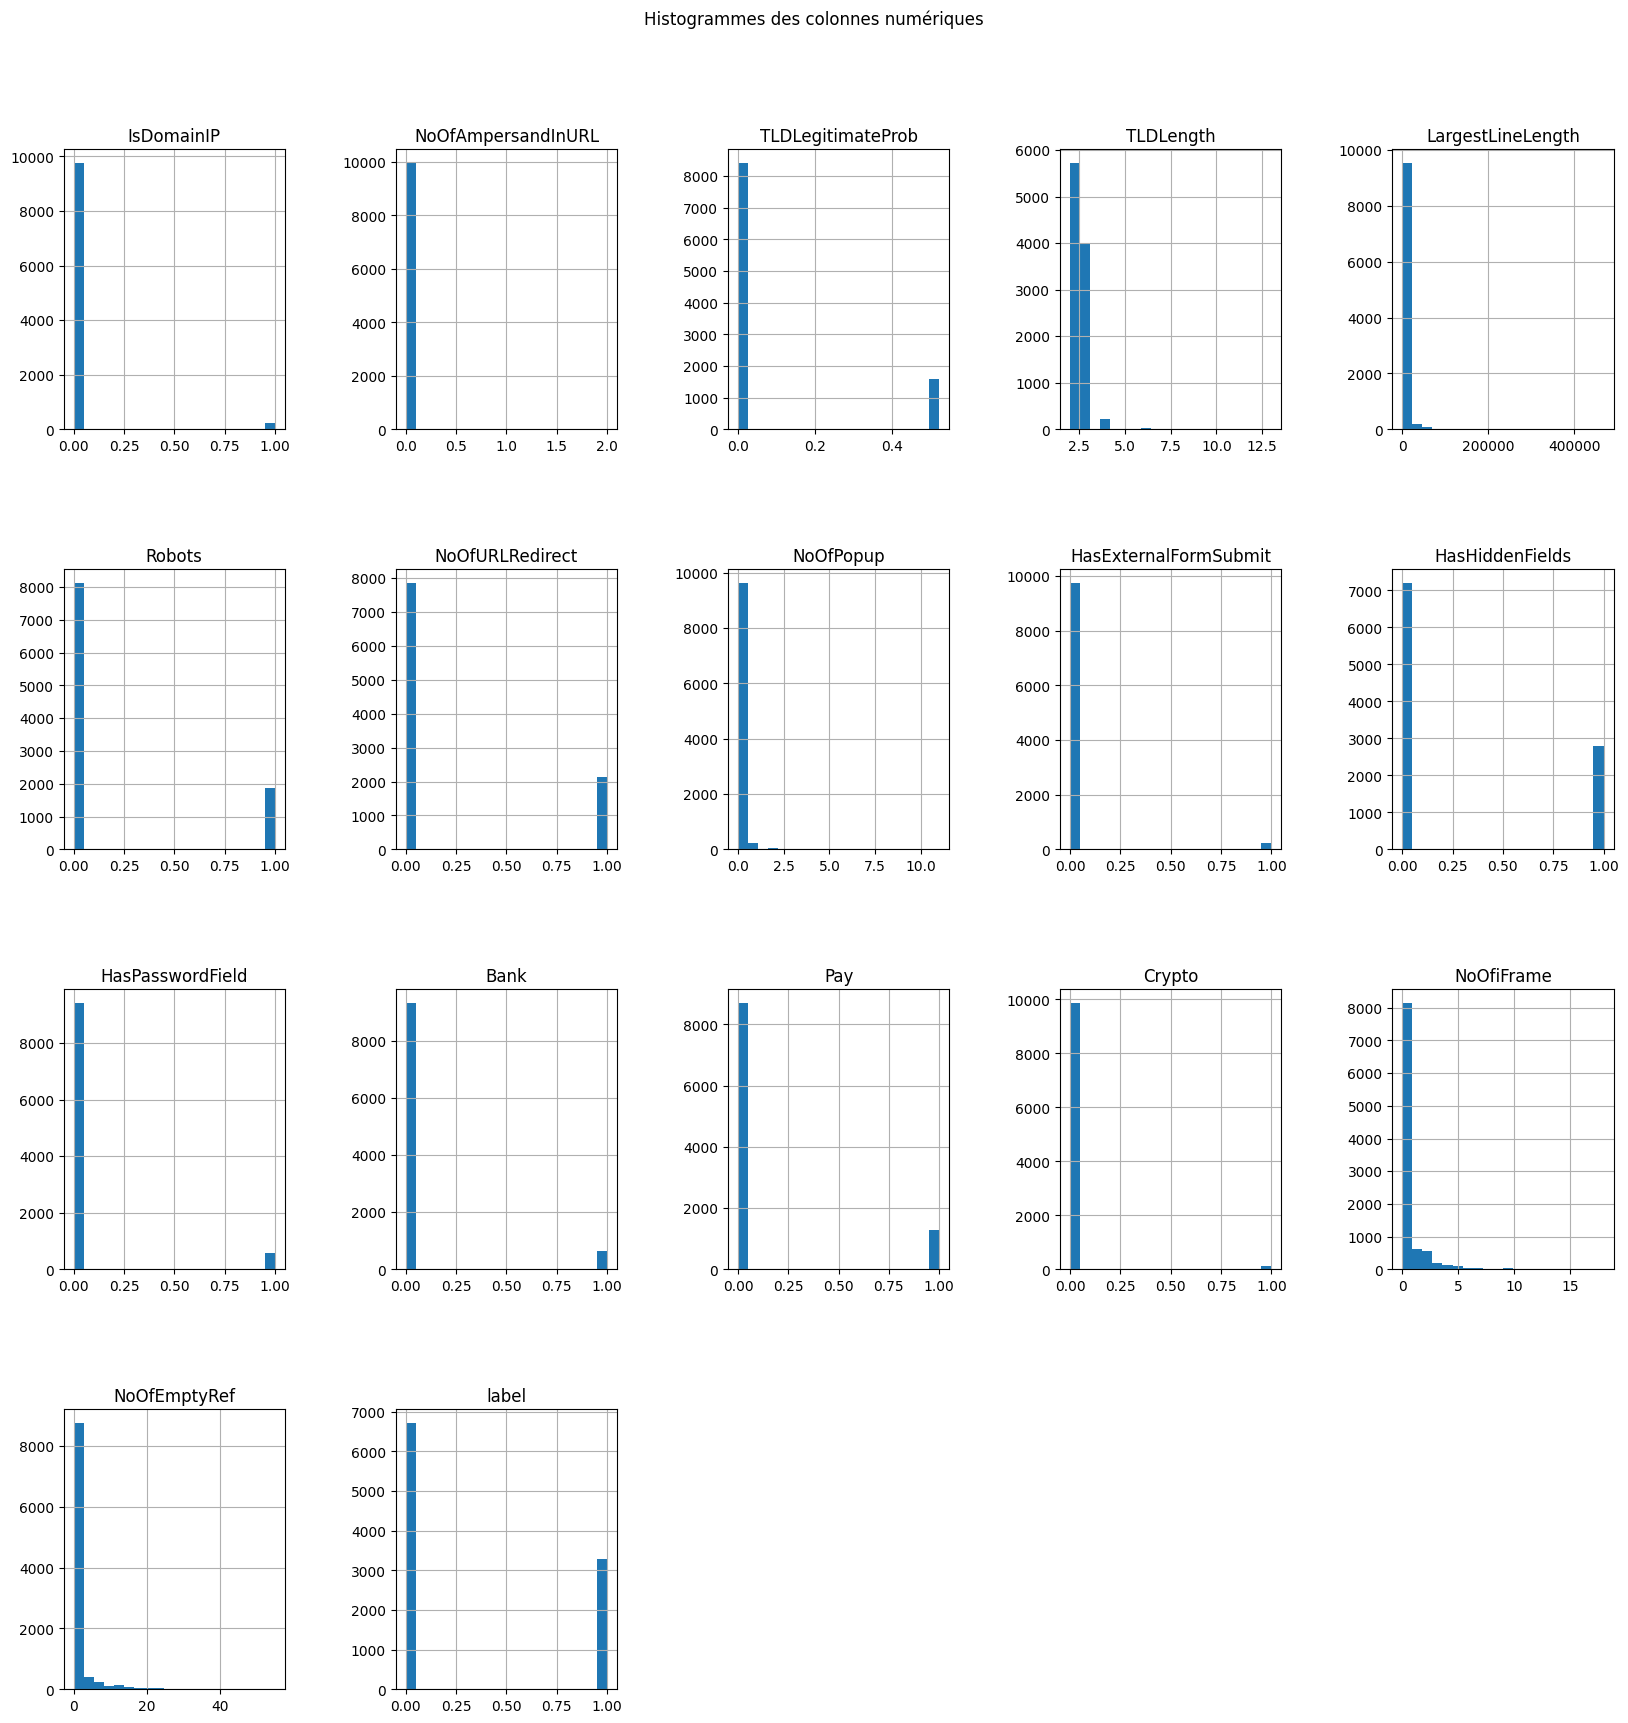

In [466]:
# Nombre de colonnes numériques dans le dataset
num_columns = len(df.select_dtypes(include=['float64', 'int64']).columns)

# Calculer dynamiquement le nombre de lignes et de colonnes pour les subplots
ncols = 5  # Tu peux changer ce nombre si tu préfères une autre disposition
nrows = math.ceil(num_columns / ncols)

# Affichage des histogrammes avec une disposition dynamique
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Si le nombre de colonnes n'est pas un multiple de ncols, certaines cases peuvent être vides
axes = axes.flatten()

for i, col in enumerate(df.select_dtypes(include=['float64', 'int64']).columns):
    df[col].hist(ax=axes[i], bins=20)
    axes[i].set_title(col)

# Cacher les axes inutilisés si le nombre de colonnes est inférieur au nombre de sous-graphiques
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Histogrammes des colonnes numériques", y=0.95)  # Réduire l'espace avec y=0.95
plt.show()



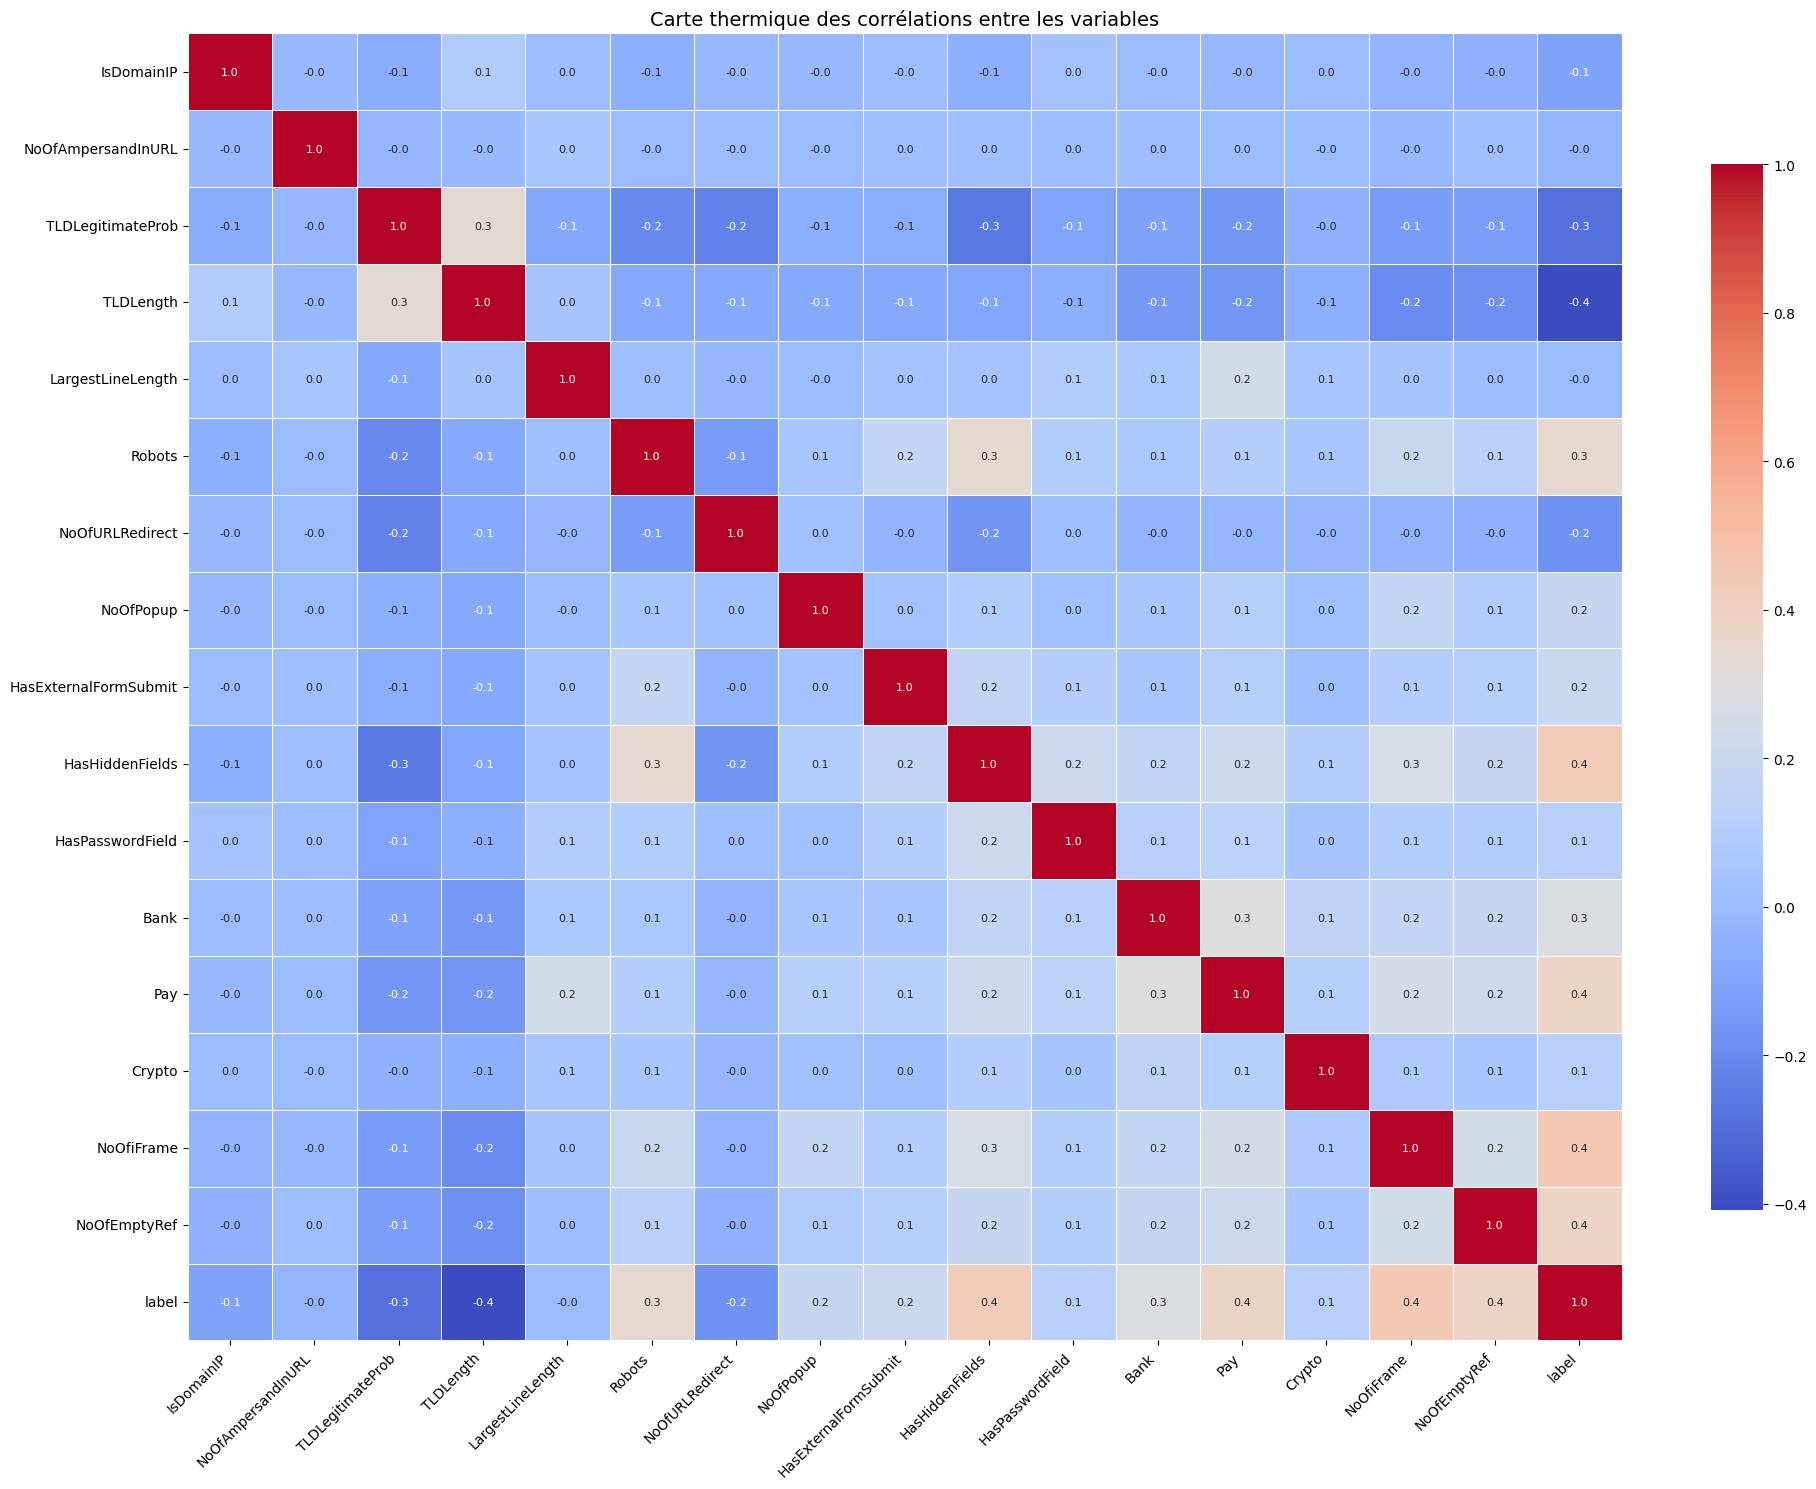

' # Afficher le tableau des corrélations élevées sous forme de carte thermique\nplt.figure(figsize=(12, 8))\nsns.heatmap(high_corr_cleaned, annot=True, cmap=\'coolwarm\', linewidths=0.5, fmt=".2f")\nplt.title("Carte thermique des corrélations > 0.6 et < 1.0")\nplt.xticks(rotation=45, ha=\'right\', fontsize=10)\nplt.yticks(fontsize=10)\nplt.tight_layout()\nplt.show() '

In [467]:
# Étape 4 : Analyse des corrélations
# Sélectionner uniquement les colonnes numériques
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Calcul de la matrice de corrélation pour toutes les colonnes numériques
correlation_matrix = df.corr()

# Taille de la figure augmentée pour meilleure lisibilité
plt.figure(figsize=(20, 15))

# Affichage de la carte thermique (heatmap) avec ajustement des paramètres
sns.heatmap(correlation_matrix, 
            annot=True,               # Afficher les valeurs
            fmt=".1f",                # Limiter les décimales à 1 chiffre
            cmap='coolwarm',          # Palette de couleurs
            linewidths=0.5,           # Espacement entre les carrés
            annot_kws={"size": 8},    # Taille de la police pour les annotations
            cbar_kws={'shrink': 0.8}) # Taille de la barre de couleur

# Ajuster la taille des labels pour qu'ils ne se chevauchent pas
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotation des labels des colonnes
plt.yticks(fontsize=10)

plt.title("Carte thermique des corrélations entre les variables", fontsize=14)
plt.tight_layout()  # Ajustement des marges
plt.show()


# Filtrer la matrice de corrélation pour les valeurs > 0.6 et < 1
high_corr = correlation_matrix[(correlation_matrix > 0.6) & (correlation_matrix < 1.0)]

# Supprimer les colonnes/lignes où toutes les valeurs sont NaN (non corrélées dans cet intervalle)
high_corr_cleaned = high_corr.dropna(how='all').dropna(axis=1, how='all')

""" # Afficher le tableau des corrélations élevées sous forme de carte thermique
plt.figure(figsize=(12, 8))
sns.heatmap(high_corr_cleaned, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Carte thermique des corrélations > 0.6 et < 1.0")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show() """

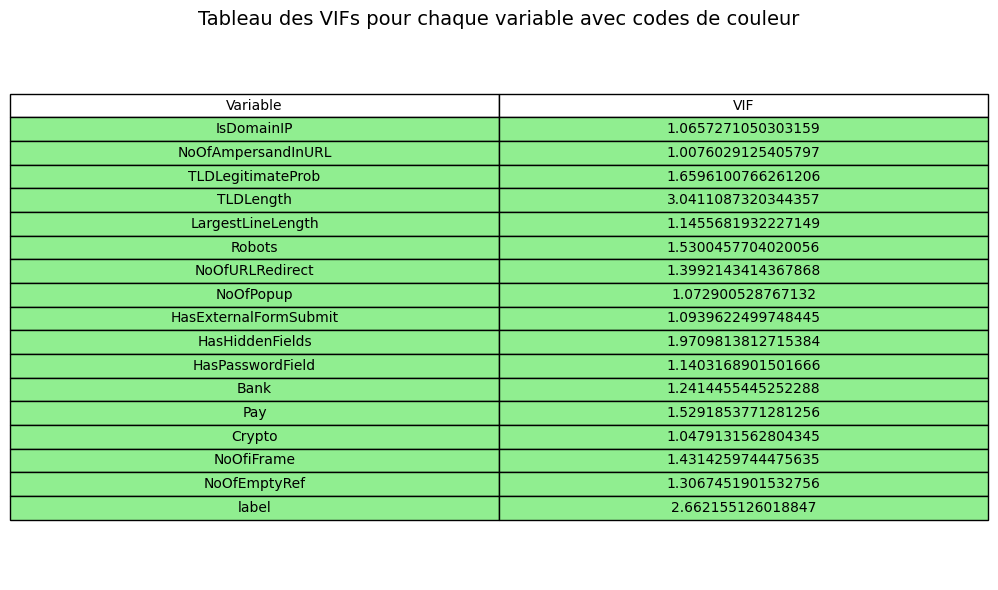

In [468]:
# Étape 1 : Calculer le VIF pour chaque colonne
vif_data = pd.DataFrame()
vif_data["Variable"] = df_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(df_numeric.values, i) for i in range(df_numeric.shape[1])]

# Étape 2 : Définir des couleurs basées sur les niveaux de multicolinéarité
colors = []
for vif in vif_data["VIF"]:
    if vif < 5:
        colors.append("lightgreen")  # Pas de multicolinéarité (VIF < 5)
    elif 5 <= vif < 10:
        colors.append("yellow")      # Faible à modérée multicolinéarité (5 <= VIF < 10)
    elif 10 <= vif < 20:
        colors.append("orange")      # Modérée à forte multicolinéarité (10 <= VIF < 20)
    else:
        colors.append("red")         # Forte multicolinéarité (VIF >= 20)

# Étape 3 : Afficher les résultats dans un tableau avec des couleurs
fig, ax = plt.subplots(figsize=(10, 6))

# Masquer les axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Créer le tableau avec Matplotlib
table = ax.table(cellText=vif_data.values, colLabels=vif_data.columns, cellLoc='center', loc='center')

# Appliquer les couleurs aux lignes
for i, color in enumerate(colors):
    table[(i + 1, 0)].set_facecolor(color)  # Appliquer la couleur à la colonne "Variable"
    table[(i + 1, 1)].set_facecolor(color)  # Appliquer la couleur à la colonne "VIF"

# Ajuster la taille du texte et l'échelle du tableau pour qu'il soit lisible
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Ajouter un titre au tableau
plt.title("Tableau des VIFs pour chaque variable avec codes de couleur", fontsize=14)

# Ajuster le layout pour une meilleure présentation
plt.tight_layout()

# Afficher le tableau
plt.show()

c:\Users\sacha\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
c:\Users\sacha\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


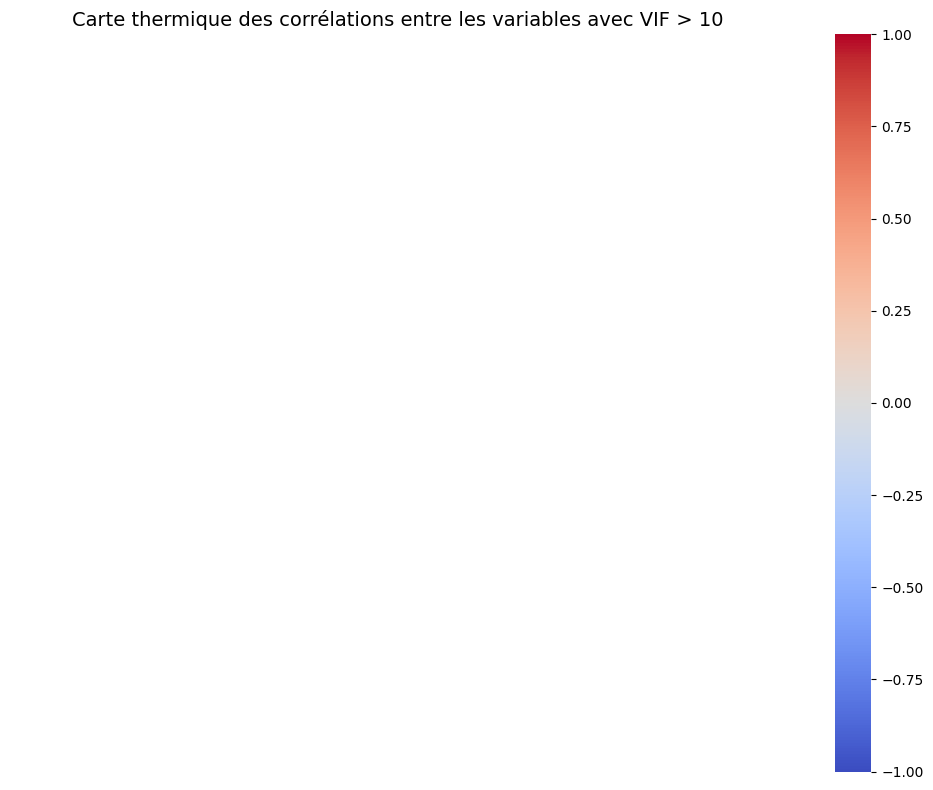

In [469]:
# Étape 1 : Identifier les variables ayant un VIF supérieur à 10
problematic_variables = vif_data[vif_data["VIF"] > 5]["Variable"].tolist()

# Étape 2 : Filtrer la matrice de corrélation pour ne garder que les variables problématiques
problematic_corr_matrix = correlation_matrix.loc[problematic_variables, problematic_variables]

# Étape 3 : Afficher une carte thermique (heatmap) des corrélations entre ces variables problématiques
plt.figure(figsize=(10, 8))
sns.heatmap(problematic_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title("Carte thermique des corrélations entre les variables avec VIF > 10", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [470]:
# Créer une requête SQL pour sélectionner toutes les colonnes sauf celles à supprimer
query = f"""
CREATE OR REPLACE TABLE `{dataset_id}.{table_id_colinearite_vif}` AS
SELECT
    DegitRatioInURL,
    Domain,
    IsDomainIP,
    NoOfAmpersandInURL,
    NoOfOtherSpecialCharsInURL,
    Title,
    URL,
    TLDLegitimateProb,
    TLDLength,
    SpacialCharRatioInURL,
    LargestLineLength,
    Robots,
    NoOfURLRedirect,
    NoOfPopup,
    HasExternalFormSubmit,
    HasHiddenFields,
    HasPasswordField,
    Bank,
    Pay,
    Crypto,
    NoOfiFrame,
    NoOfEmptyRef,
    TLD,
    label
FROM `{dataset_id}.{table_id}`
"""

# Exécuter la requête SQL pour créer la nouvelle table
query_job = client.query(query)

# Attendre que la requête se termine
query_job.result()

print(f"Table '{table_id_colinearite_vif}' créée avec succès et contient les colonnes sélectionnées.")

Table 'sacha_table_NA_colin' créée avec succès et contient les colonnes sélectionnées.


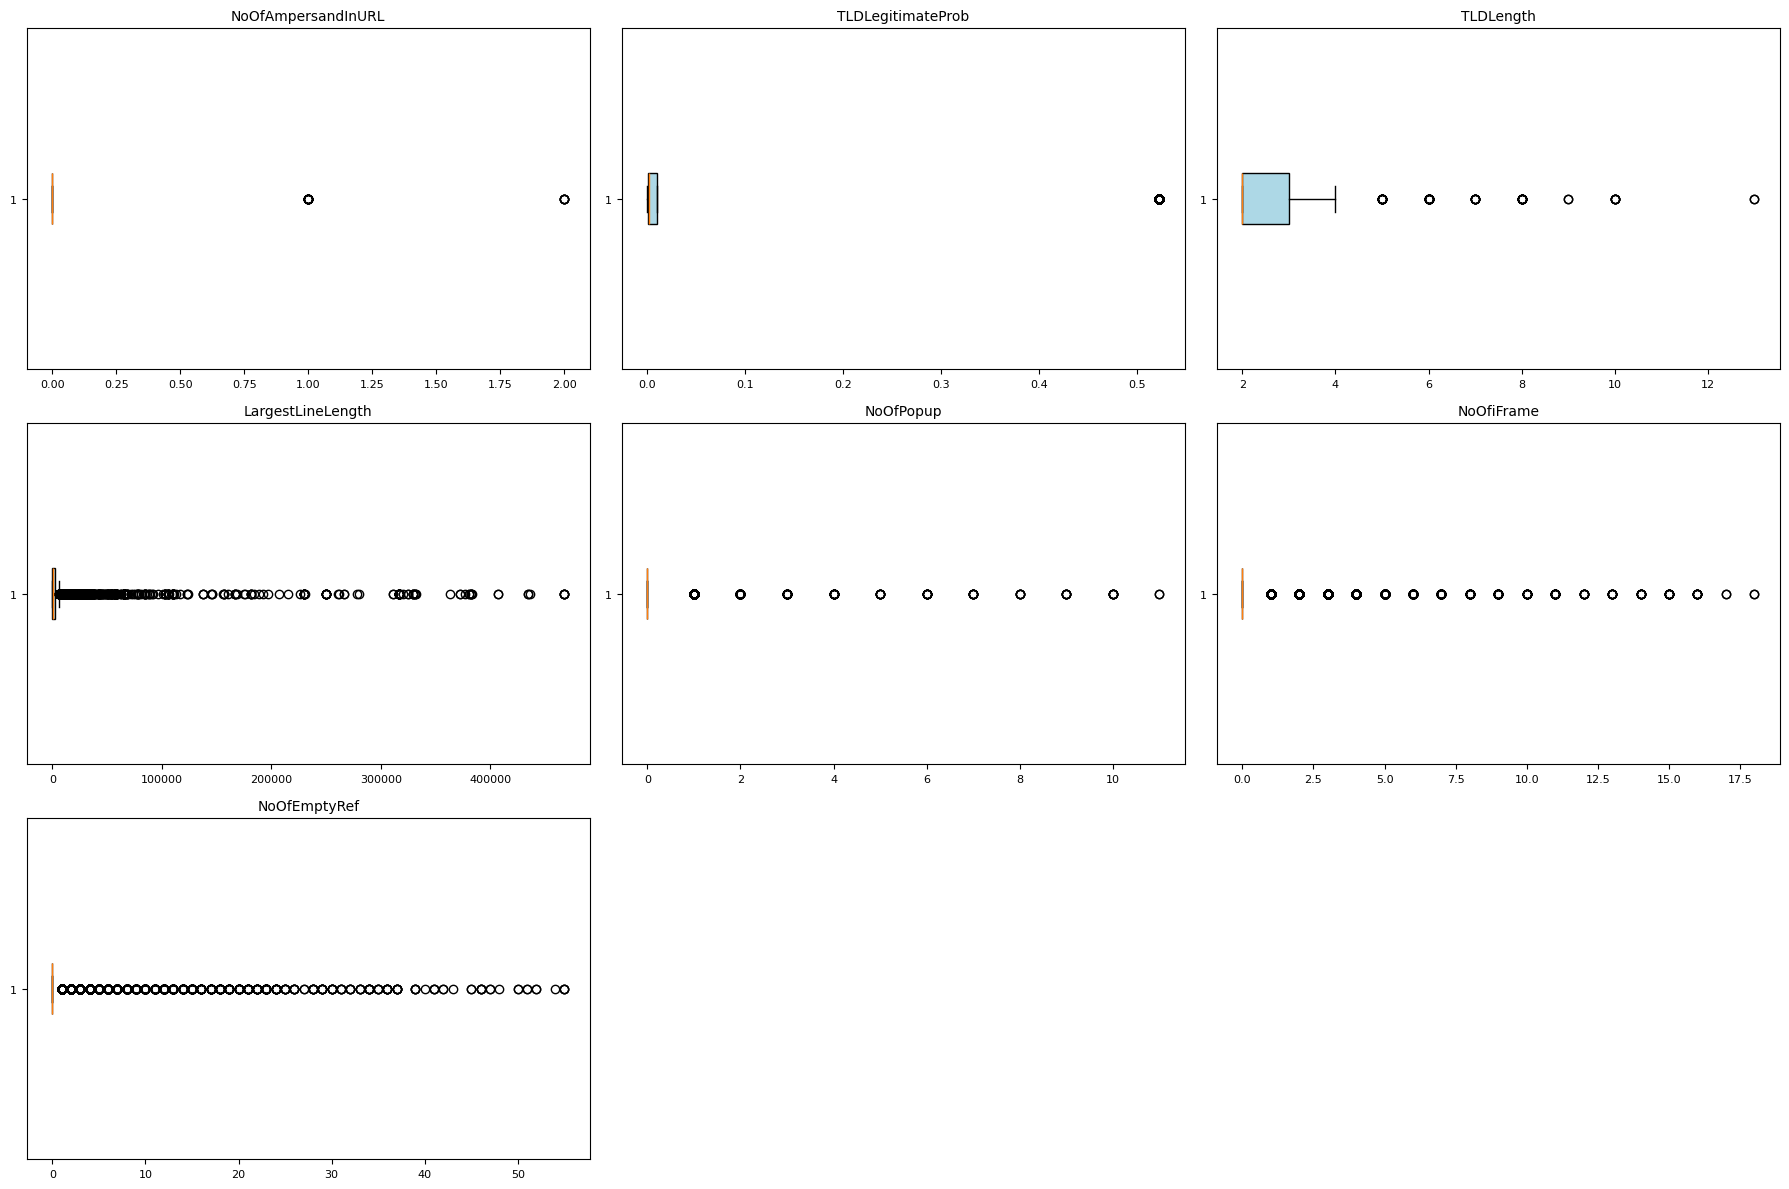

Nombre d'outliers identifiés par z-score dans chaque colonne non binaire :
NoOfAmpersandInURL     24
TLDLegitimateProb       0
TLDLength              73
LargestLineLength     136
NoOfPopup             138
NoOfiFrame            220
NoOfEmptyRef          245
dtype: int64
Nombre de lignes avant suppression des outliers : 10000
Nombre de lignes après suppression des outliers : 9233


In [471]:
# Étape 1 : Sélection des colonnes non binaires
non_binary_columns = [col for col in df_numeric.columns if df_numeric[col].nunique() > 2]
df_non_binary = df_numeric[non_binary_columns]

# Étape 2 : Créer des box plots pour visualiser les outliers dans les colonnes non binaires
def create_box_plots(df):
    num_columns = len(df.columns)
    rows = int(np.ceil(num_columns / 3))  # Adjust to have 3 plots per row
    fig, axes = plt.subplots(rows, 3, figsize=(18, rows * 4))  # Increase figure size for better clarity
    axes = axes.flatten()
    
    for i, col in enumerate(df.columns):
        axes[i].boxplot(df[col], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
        axes[i].set_title(col, fontsize=10)
        axes[i].tick_params(axis='x', labelsize=8)  # Increase tick label size for readability
        axes[i].tick_params(axis='y', labelsize=8)
    
    for j in range(i+1, len(axes)):  # Turn off unused subplots
        axes[j].axis('off')
        
    plt.tight_layout()
    plt.show()

# Afficher les box plots pour les colonnes non binaires
create_box_plots(df_non_binary)

# Étape 3 : Identifier les outliers avec des z-scores dans les colonnes non binaires
def identify_outliers_with_zscore(df):
    z_scores = np.abs(stats.zscore(df))
    outliers = (z_scores > 3).sum(axis=0)  # Compter les valeurs avec z-score > 3 pour chaque colonne
    print("Nombre d'outliers identifiés par z-score dans chaque colonne non binaire :")
    print(outliers)

# Identifier les outliers dans les colonnes non binaires
identify_outliers_with_zscore(df_non_binary)

# Étape 4 : Supprimer les outliers dans les colonnes non binaires (z-score > 3)
def remove_outliers(df):
    z_scores = np.abs(stats.zscore(df))
    df_clean = df[(z_scores < 3).all(axis=1)]  # Conserver uniquement les lignes où toutes les valeurs sont dans la limite des z-scores
    return df_clean

# Supprimer les outliers dans les colonnes non binaires
df_non_binary_clean = remove_outliers(df_non_binary)

# Vérifier le nombre de lignes avant et après suppression des outliers
print(f"Nombre de lignes avant suppression des outliers : {df_non_binary.shape[0]}")
print(f"Nombre de lignes après suppression des outliers : {df_non_binary_clean.shape[0]}")

In [472]:
query = f"""
CREATE OR REPLACE TABLE `{dataset_id}.{table_id_outliers_vif}` AS
WITH zscore_filtered AS (
  SELECT *,
    -- Calculate z-scores only for numeric columns (columns where outliers matter)
    ABS((TLDLegitimateProb - AVG(TLDLegitimateProb) OVER()) / STDDEV(TLDLegitimateProb) OVER()) AS z_TLDLegitimateProb,
    ABS((NoOfLettersInURL - AVG(NoOfLettersInURL) OVER()) / STDDEV(NoOfLettersInURL) OVER()) AS z_NoOfLettersInURL,
    ABS((NoOfDegitsInURL - AVG(NoOfDegitsInURL) OVER()) / STDDEV(NoOfDegitsInURL) OVER()) AS z_NoOfDegitsInURL,
    ABS((DegitRatioInURL - AVG(DegitRatioInURL) OVER()) / STDDEV(DegitRatioInURL) OVER()) AS z_DegitRatioInURL,
    ABS((NoOfEqualsInURL - AVG(NoOfEqualsInURL) OVER()) / STDDEV(NoOfEqualsInURL) OVER()) AS z_NoOfEqualsInURL,
    ABS((NoOfAmpersandInURL - AVG(NoOfAmpersandInURL) OVER()) / STDDEV(NoOfAmpersandInURL) OVER()) AS z_NoOfAmpersandInURL,
    ABS((LargestLineLength - AVG(LargestLineLength) OVER()) / STDDEV(LargestLineLength) OVER()) AS z_LargestLineLength,
    ABS((URLTitleMatchScore - AVG(URLTitleMatchScore) OVER()) / STDDEV(URLTitleMatchScore) OVER()) AS z_URLTitleMatchScore,
    ABS((NoOfPopup - AVG(NoOfPopup) OVER()) / STDDEV(NoOfPopup) OVER()) AS z_NoOfPopup,
    ABS((NoOfiFrame - AVG(NoOfiFrame) OVER()) / STDDEV(NoOfiFrame) OVER()) AS z_NoOfiFrame,
    ABS((NoOfEmptyRef - AVG(NoOfEmptyRef) OVER()) / STDDEV(NoOfEmptyRef) OVER()) AS z_NoOfEmptyRef,
  FROM `{dataset_id}.{table_id}`
)

-- Step 2: Filter rows where no z-score exceeds 3 for any numeric column
SELECT
  -- Include all original columns from the table
  URL, Domain, IsDomainIP, TLD,
  TLDLegitimateProb, TLDLength,
  NoOfLettersInURL, NoOfDegitsInURL, DegitRatioInURL,
  NoOfEqualsInURL, NoOfAmpersandInURL,
  LargestLineLength, Title,
  URLTitleMatchScore, Robots, NoOfURLRedirect,
  NoOfPopup, NoOfiFrame,
  NoOfEmptyRef, HasExternalFormSubmit, 
  HasHiddenFields, HasPasswordField, Bank, Pay, Crypto, label
FROM zscore_filtered
WHERE
  z_TLDLegitimateProb <= 3
  AND z_NoOfLettersInURL <= 3
  AND z_NoOfDegitsInURL <= 3
  AND z_DegitRatioInURL <= 3
  AND z_NoOfEqualsInURL <= 3
  AND z_NoOfAmpersandInURL <= 3
  AND z_LargestLineLength <= 3
  AND z_URLTitleMatchScore <= 3
  AND z_NoOfPopup <= 3
  AND z_NoOfiFrame <= 3
  AND z_NoOfEmptyRef <= 3

"""


# Exécuter la requête SQL pour créer la nouvelle table
query_job = client.query(query)

# Attendre que la requête se termine
query_job.result()

print(f"Table '{table_id_colinearite_vif}' créée avec succès et contient les colonnes sélectionnées.")

Table 'sacha_table_NA_colin' créée avec succès et contient les colonnes sélectionnées.


In [473]:
query = f"""
CREATE OR REPLACE TABLE `{dataset_id}.{table_id_outli_colin_vif}` AS
WITH zscore_filtered AS (
  SELECT *,
    -- Calculate z-scores only for numeric columns (columns where outliers matter)
    ABS((TLDLegitimateProb - AVG(TLDLegitimateProb) OVER()) / STDDEV(TLDLegitimateProb) OVER()) AS z_TLDLegitimateProb,
    ABS((NoOfDegitsInURL - AVG(NoOfDegitsInURL) OVER()) / STDDEV(NoOfDegitsInURL) OVER()) AS z_NoOfDegitsInURL,
    ABS((NoOfAmpersandInURL - AVG(NoOfAmpersandInURL) OVER()) / STDDEV(NoOfAmpersandInURL) OVER()) AS z_NoOfAmpersandInURL,
    ABS((LargestLineLength - AVG(LargestLineLength) OVER()) / STDDEV(LargestLineLength) OVER()) AS z_LargestLineLength,
    ABS((NoOfPopup - AVG(NoOfPopup) OVER()) / STDDEV(NoOfPopup) OVER()) AS z_NoOfPopup,
    ABS((NoOfiFrame - AVG(NoOfiFrame) OVER()) / STDDEV(NoOfiFrame) OVER()) AS z_NoOfiFrame,
    ABS((NoOfEmptyRef - AVG(NoOfEmptyRef) OVER()) / STDDEV(NoOfEmptyRef) OVER()) AS z_NoOfEmptyRef,
  FROM `{dataset_id}.{table_id}`
)

-- Step 2: Filter rows where no z-score exceeds 3 for any numeric column
SELECT
  -- Include all original columns from the table
  URL, Domain, IsDomainIP, TLD,
  TLDLegitimateProb, TLDLength,
  NoOfDegitsInURL,
  NoOfAmpersandInURL,
  LargestLineLength, Title,
  Robots, NoOfURLRedirect,
  NoOfPopup, NoOfiFrame,
  NoOfEmptyRef, HasExternalFormSubmit, 
  HasHiddenFields, HasPasswordField, Bank, Pay, Crypto, label
FROM zscore_filtered
WHERE
  z_TLDLegitimateProb <= 3
  AND z_NoOfDegitsInURL <= 3
  AND z_NoOfAmpersandInURL <= 3
  AND z_LargestLineLength <= 3
  AND z_NoOfPopup <= 3
  AND z_NoOfiFrame <= 3
  AND z_NoOfEmptyRef <= 3

"""


# Exécuter la requête SQL pour créer la nouvelle table
query_job = client.query(query)

# Attendre que la requête se termine
query_job.result()

print(f"Table '{table_id_outli_colin_vif}' créée avec succès et contient les colonnes sélectionnées.")

Table 'sacha_table_NA_outli_colin' créée avec succès et contient les colonnes sélectionnées.


In [474]:
table_id_stagging = "sacha_table_initial_stagging"
table_id_stagging_string = "sacha_table_initial_stagging_NA_string"

query = f"""
CREATE OR REPLACE TABLE `{dataset_id}.{table_id_stagging}` AS
SELECT *
FROM `{dataset_id}.{table_id_outli_colin_vif}`
"""

query2 = f"""
CREATE OR REPLACE TABLE `{dataset_id}.{table_id_stagging_string}` AS
SELECT     
    IsDomainIP,
    NoOfAmpersandInURL,
    TLDLegitimateProb,
    TLDLength,
    LargestLineLength,
    Robots,
    NoOfURLRedirect,
    NoOfPopup,
    HasExternalFormSubmit,
    HasHiddenFields,
    HasPasswordField,
    Bank,
    Pay,
    Crypto,
    NoOfiFrame,
    NoOfEmptyRef,
    label
FROM `{dataset_id}.{table_id_outli_colin_vif}`
"""

# Exécuter la requête SQL pour créer la nouvelle table
query_job = client.query(query)
query_job2 = client.query(query2)

# Attendre que la requête se termine
query_job.result()
query_job2.result()

print(f"Table '{table_id_outli_colin_vif}' créée avec succès et contient les colonnes sélectionnées.")

Table 'sacha_table_NA_outli_colin' créée avec succès et contient les colonnes sélectionnées.
